# Figures

This notebook will create the figures for the manuscript.

First import the benchmark variants.

In [1]:
# kernel is the `utr_curation_manuscript` conda env

import shelve
import seaborn as sns
import pandas as pd
import numpy as np
import string

from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

utr3_df = pd.read_csv('data/utr3_plp_benchmark.tsv', sep='\t')
utr5_df = pd.read_csv('data/utr5_plp_benchmark.tsv', sep='\t')
utr3_df['region'] = 'utr3'
utr5_df['region'] = 'utr5'

utr5_df['proposed_mechanism'] = utr5_df.apply(lambda x: "Undetermined" if (pd.isnull(x['proposed_mechanism']) and x['class'] == 1) else x.proposed_mechanism, axis=1)
utr3_df['proposed_mechanism'] = utr3_df.apply(lambda x: "Undetermined" if (pd.isnull(x['proposed_mechanism']) and x['class'] == 1) else x.proposed_mechanism, axis=1)


# Import predictions


In [2]:
# KAROLLUS (FRAMEPOOLCOMBINED)

karollus_df = pd.read_csv('output/karollus_predictions_20230221.tsv', sep='\t')
karollus_df = karollus_df.rename(index=str, columns={"metadata/chr":"chr",
          "metadata/exon_positions":"exon_positions",
          "metadata/id":"transcript_id",
          "metadata/strand":"strand",
          "metadata/variants":"variant",
          "preds/mrl_fold_change":"mrl_fold_change",
          "preds/shift_1":"shift_1",
          "preds/shift_2":"shift_2"})
karollus_df['variant'] = karollus_df['variant'].str.replace('>', ':')
# merge on the base transcript since there are some versioning differences
karollus_df[['transcript_id_base', 'transcript_id_version']] = karollus_df['transcript_id'].str.split('.', expand=True)
utr5_df[['transcript_id_base', 'transcript_id_version']] = utr5_df['transcript_id'].str.split('.', expand=True)

# join karollus predictions and metadata
karollus_df = utr5_df.merge(karollus_df, how='left', on=['variant', 'transcript_id_base']).drop_duplicates()

In [3]:
# SALUKI
saluki_df = pd.read_csv('output/saluki_predictions_20230221.tsv', sep='\t')
# take the average of each model
saluki_df = saluki_df.groupby(by=['variant'])['score'].mean().reset_index()
# merge to metadata
saluki_df = utr3_df.merge(saluki_df, how='left', on='variant')


In [4]:
# SKIP THIS CELL IF THE TSV AT THE END EXISTS ALREADY

# Enformer - predictions are in a shelve file

TARGETS_TXT = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'

targets_df = pd.read_csv(TARGETS_TXT, sep='\t')
cage_idx = targets_df.query('description.str.startswith("CAGE")').index.to_list()

# read results 
def transform_enformer_output(pred, middle_window, track_indices):
    pred = pred[(middle_window-2):(middle_window+3), track_indices]
    # sum across bins
    pred = np.sum(pred, axis=0)
    # transform and take the mean of the tracks
    pred = np.mean(np.log2(pred + 1))
    return pred

results_variants = list()
results_score = list()
with shelve.open('output/enformer_predictions_20230216.shelve') as results:
    for variant, pred in results.items():
        results_variants.append(variant)
        assert pred['ref'].shape == pred['alt'].shape
        middle_window = pred['ref'].shape[0] // 2
        assert middle_window == 448

        score = (transform_enformer_output(pred['alt'], middle_window, cage_idx) \
            - transform_enformer_output(pred['ref'], middle_window, cage_idx)
        )
        results_score.append(score)
# create df
enformer_df = pd.DataFrame({
    'variant': results_variants,
    'score': results_score
})

# merge to metadata
enformer_df = utr5_df.merge(enformer_df, how='left', on =['variant'])

# also write out a df of the Enformer processed scores - for ease of access later
enformer_df.to_csv('output/enformer_predictions_20230216.tsv', index=False, sep='\t')

In [263]:
# Enformer - if a .tsv exists already
enformer_df = pd.read_csv("output/enformer_predictions_20230216.tsv", sep="\t")
enformer_df = utr5_df.merge(enformer_df[["variant", "score"]], how='left', on =['variant'])


In [10]:
# Polyphen
phylop_results = pd.read_csv('output/phylop_annotations_20230222.tsv', sep='\t')
phylop_results['label'] = phylop_results['class'].apply(lambda x: 'P/LP' if x == 1 else 'Putative Benign')
phylop_results['region_label'] = phylop_results['region'].apply(lambda x: "5' UTR" if x == 'utr5' else "3' UTR")
# just extract score and variant column and merge to the utr3 and utr5 df
utr_merged = pd.concat([utr5_df.drop(columns=["transcript_id_base", "transcript_id_version"]), utr3_df], axis=0)
phylop_results = utr_merged.merge(
    phylop_results[["variant", "phylop_100way", "region_label", "label"]], how="left", left_on=["variant"], right_on=["variant"]
)
phylop_results = phylop_results.drop_duplicates()
phylop_results.groupby(["class", "region"]).size()

class  region
0      utr3      67
       utr5      24
1      utr3      26
       utr5      68
dtype: int64

In [7]:
# create an absolutes core column for each mechanism
karollus_df["abs_score"] = abs(karollus_df["mrl_fold_change"])
saluki_df["abs_score"] = abs(saluki_df["score"])
enformer_df["abs_score"] = abs(enformer_df["score"])


# ANALYSIS

I think that this predictor analysis can support the curation by showing that for the specific mechanisms 
that these models are supposed to probe for, we see a significant difference in their range of scores. Not just
between the P/LP variants of that specific mechanism and the putative benign variants, but
also of the P/LP variants of that mechanism vs. all other P/LP variants.

However, before we try that, we should try plotting the variants grouped by pathogenicity, regardless of mechanism.


## All P/LP vs. all putative benign (Figure S2)

1 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.225e-04 U_stat=1.213e+03
1 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.250e-09 U_stat=1.581e+03
1 vs. 0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.419e-02 U_stat=1.070e+03
3' UTR_P/LP vs. 3' UTR_Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:2.279e-07 U_stat=1.476e+03
5' UTR_P/LP vs. 5' UTR_Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:4.824e-04 U_stat=1.209e+03


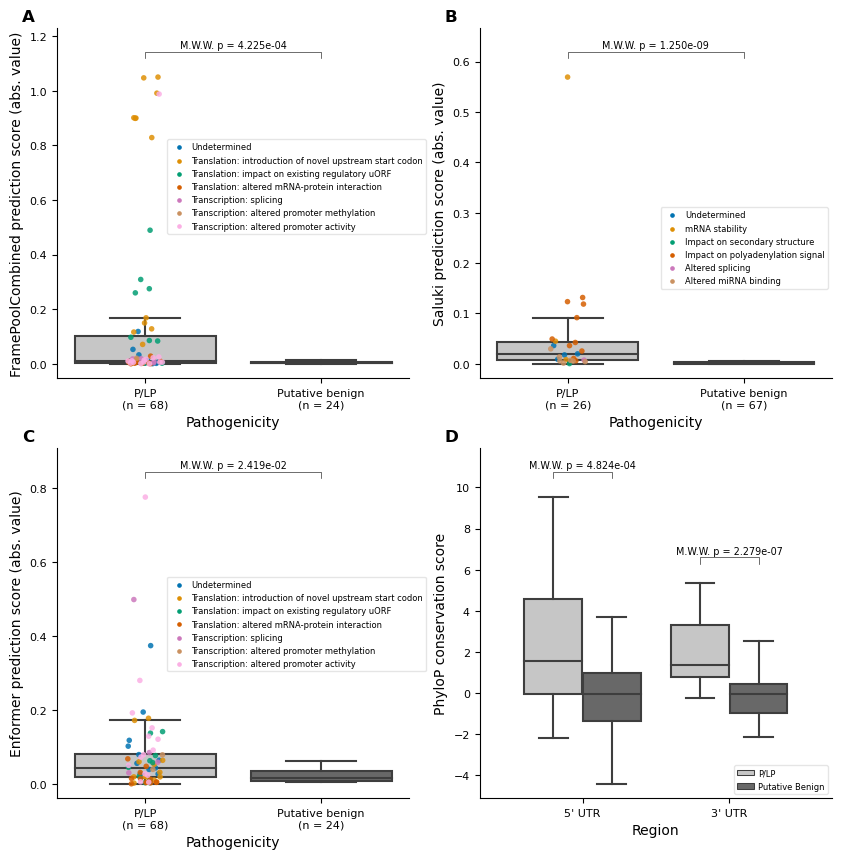

In [57]:
# boxplot aesthetics
plt.rcParams["legend.markerscale"] = 0.3
plt.rcParams["legend.framealpha"] = 0.5
plt.rcParams["legend.handletextpad"] = 0.5


## BOXPLOT WHERE WE JUST ALL P/LP WITH BENIGN

def create_general_plp_vs_benign_boxplot(ax_n, df, x, y, order, pairs, ylabel, xlabel, legend_loc):
     
    counts_dict = df["class"].value_counts().to_dict()
    rename_dict = {1: "P/LP", 0: "Putative benign"}  # rename class 1 to P/LP for the plot, etc.

    # forces all to be lower case so there are no differences between sorting based on case
    # this sort is to consistently get Undetermined as the first element so 
    # it is the same color between the 5' UTR and 3' UTR plots
    df = df.sort_values(by=["proposed_mechanism"], ascending=False, key=lambda col: col.str.lower())
    
    ax_n.clear()
    ax = sns.boxplot(ax=ax_n, data=df, x=x, y=y, order=order, palette='Greys', showfliers=False)
    f = sns.stripplot(
        data=df, x=x, y=y, hue="proposed_mechanism",
        dodge=False, jitter=True, ax=ax_n, size=4, order=order, palette="colorblind", alpha=0.85)
    labels = [f'{rename_dict[x]}\n(n = {counts_dict[x]})' for x in order]

    # aesthetics
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax_n.legend(bbox_to_anchor=legend_loc, fontsize=6)

    # stats
    annot = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
    annot.configure(test='Mann-Whitney', text_format='full', loc='inside', verbose=2, fontsize='x-small', line_width=0.5)
    annot.apply_test()
    annot.annotate()

    sns.despine()
    
fig_g, axes_g = plt.subplots(2, 2, figsize=(10, 10))  # g - general

order = [1, 0]
pairs = [(1, 0)]
create_general_plp_vs_benign_boxplot(
    ax_n=axes_g[0,0],
    df=karollus_df,
    x='class',
    y='abs_score',
    pairs=pairs, order=order,
    ylabel='FramePoolCombined prediction score (abs. value)',
    xlabel='Pathogenicity',
    legend_loc=(0.3, 0.4),
)

create_general_plp_vs_benign_boxplot(
    ax_n=axes_g[0,1],
    df=saluki_df, x='class', y='abs_score',
    order=order, pairs=pairs,
    ylabel='Saluki prediction score (abs. value)',
    xlabel='Pathogenicity',
    legend_loc=(1, 0.5),

)

create_general_plp_vs_benign_boxplot(
    ax_n=axes_g[1,0],
    df=enformer_df, x='class', y='abs_score',
    order=order, pairs=pairs,
    ylabel='Enformer prediction score (abs. value)',
    xlabel='Pathogenicity',
    legend_loc=(0.3, 0.35),
)

# this plot won't change for all iterations of the boxplot figure
def create_polyphen_plot(ax_n, phylop_results):
    ax_n.clear()
    ax = sns.boxplot(
        ax=ax_n,
        x="region_label", y="phylop_100way",
        hue="label",
        data=phylop_results, palette='Greys',
        showfliers=False)
    # sns.stripplot(
    #     ax=ax_n,
    #     data=phylop_results, x="region_label", y="phylop_100way", hue="label", color="black",
    #     dodge=True, jitter=True, size=2,
    # )
    # ax.axhline(y=1.5, linestyle='--', color='black', linewidth=1.6)

    # aesthetics
    ax.legend(title=None, loc='lower right', fontsize=6)
    ax.set_xlabel('Region', fontsize=10) 
    ax.set_ylabel('PhyloP conservation score', fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    # order legend - put Undetermined a
    handles, labels = plt.gca().get_legend_handles_labels()


    # stats
    pairs = [(("5' UTR", 'P/LP'), ("5' UTR", 'Putative Benign')),
            (("3' UTR", 'P/LP'), ("3' UTR", 'Putative Benign'))]
    annot = Annotator(ax, pairs=pairs, data=phylop_results, x='region_label', y='phylop_100way', hue='label')
    annot.configure(test='Mann-Whitney', text_format='full', loc='inside', verbose=2, fontsize='x-small', line_width=0.5)
    annot.apply_test()
    ax, test_results = annot.annotate()
    plt.setp(ax.get_xticklabels(), fontsize=8)

create_polyphen_plot(ax_n=axes_g[1,1], phylop_results=phylop_results)

# OVERALL FIGURE - ADD SUBFIGURE LABELS
for n, ax in enumerate(axes_g.flat):
    ax.text(-0.1, 1.02, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=12, weight='bold')
fig_g
fig_g.savefig('plots/figS2_predictors_boxplots_PLPgrouped_absScore.png', bbox_inches='tight',)


## P/LP stratified by mechanism type (Figure S3)

Here we group P/LP variants based on whether they operate through the mechanism of interest for that predictor.

In [41]:
# for each predictor df, annotate with column to group by
 
# karollus
orf_mechanisms = ['Translation: impact on existing regulatory uORF', 'Translation: introduction of novel upstream start codon']
# split into three categories
def annotate_variants(c, proposed_mechanism, mechanisms):
    if c == 0:
        return 'Putative Benign'
    else: 
        if proposed_mechanism in mechanisms:
            return 'P/LP (ORF mechanism)'
        else:
            return 'P/LP (Other)'
karollus_df['variant_annotation'] = karollus_df.apply(
    lambda x: annotate_variants(x['class'], x['proposed_mechanism'], orf_mechanisms), axis=1
)

# saluki
# separate out stability related mechanisms 
# (as per table 2, this will be anything that is polyadenylation and mRNA stability related; should be n = 13)
import re
def annotate_variants(c, proposed_mechanism):
    stability_regex = r'polyadenylation|stability'
    if c == 0:
        return 'Putative Benign'
    else: 
        if pd.isnull(proposed_mechanism):
            return "P/LP (Other)"
        elif re.search(stability_regex, proposed_mechanism, re.IGNORECASE):
            return 'P/LP (mRNA stability)'
        else:
            return 'P/LP (Other)'

saluki_df['variant_annotation'] = saluki_df.apply(
    lambda x: annotate_variants(x['class'], x['proposed_mechanism']), axis=1)

# enformer
# separate out transcription related mechanisms
# according to Table 3, there should be 21 transcription related variants
def annotate_variants(c, proposed_mechanism):
    transcription = r'transcription|splicing|methylation'
    if c == 0:
        return 'Putative Benign'
    else: 
        if pd.isnull(proposed_mechanism):
            return "P/LP (Other)"
        elif re.search(transcription, proposed_mechanism, re.IGNORECASE):
            return 'P/LP (Transcription)'
        else:
            return 'P/LP (Other)'

enformer_df['variant_annotation'] = enformer_df.apply(
    lambda x: annotate_variants(x['class'], x['proposed_mechanism']), axis=1)


P/LP (ORF mechanism) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:1.784e-03 U_stat=2.760e+02
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:6.730e-01 U_stat=5.740e+02
P/LP (ORF mechanism) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:5.852e-03 U_stat=1.460e+02
P/LP (mRNA stability) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:3.466e-03 U_stat=2.700e+01
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:3.245e-02 U_stat=6.000e+02
P/LP (mRNA stability) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:1.017e-04 U_stat=1.370e+02
P/LP (Transcription) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:1.556e-01 U_stat=3.740e+02
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:1.030e-01 U_stat=4.390e+02
P/LP (Transcription) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:6.095e-02 U_stat=1.600e+02
3' UTR_P/LP vs

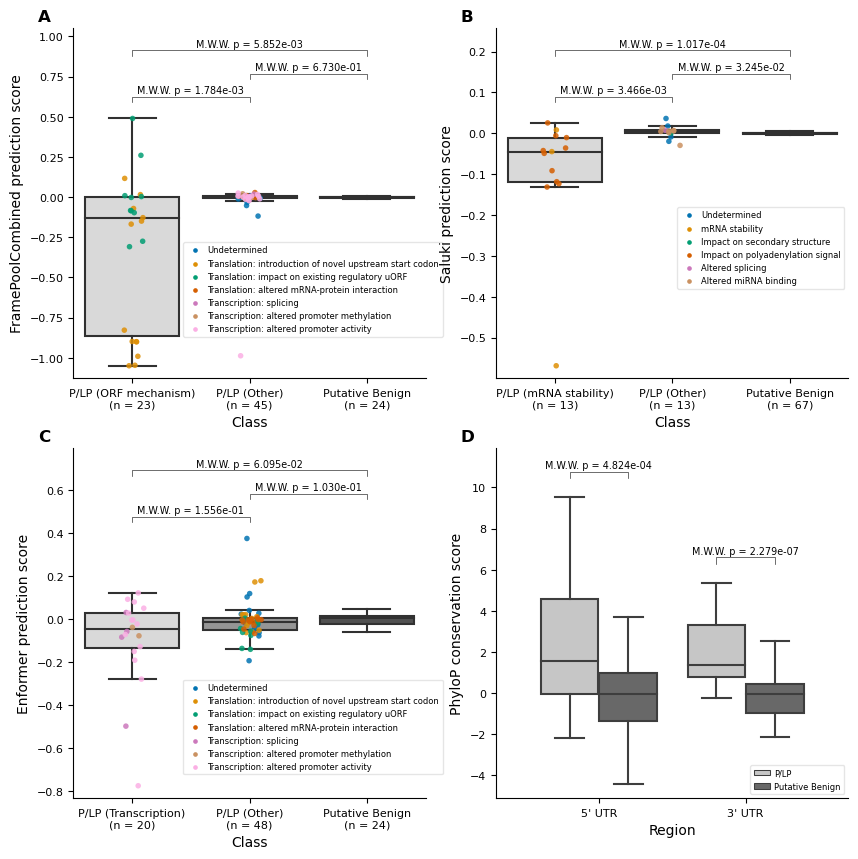

In [49]:
# code to produce the actual figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# a similar function to the one above, but does not stratify by class
def create_boxplot(ax_n, df, x, y, order, pairs, ylabel, xlabel, legend_loc):
    counts_dict = df[x].value_counts().to_dict()

    ax_n.clear()

    # forces all to be lower case so there are no differences between sorting based on case
    # this sort is to consistently get Undetermined as the first element so 
    # it is the same color between the 5' UTR and 3' UTR plots
    df = df.sort_values(by=["proposed_mechanism"], ascending=False, key=lambda col: col.str.lower())

    ax = sns.boxplot(ax=ax_n, data=df, x=x, y=y, order=order, palette='Greys', showfliers=False)
    f = sns.stripplot(
        data=df, x=x, y=y, hue="proposed_mechanism",
        dodge=False, jitter=True, ax=ax_n, size=4, order=order, palette="colorblind", alpha=0.85)
    labels = [f'{x}\n(n = {counts_dict[x]})' for x in order]

    # aesthetics
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax_n.legend(bbox_to_anchor=legend_loc, fontsize=6)

    # stats
    annot = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
    annot.configure(test='Mann-Whitney', text_format='full', loc='inside', verbose=2, fontsize='x-small', line_width=0.5)
    annot.apply_test()
    annot.annotate()

    # formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    sns.despine()

# karollus
plp_orf = 'P/LP (ORF mechanism)'
plp_other = 'P/LP (Other)'
benign = 'Putative Benign'
order = [plp_orf, plp_other, benign]
pairs = [(plp_orf, benign), (plp_orf, plp_other), (plp_other, benign)]
create_boxplot(
    ax_n=axes[0,0],
    df=karollus_df,
    x='variant_annotation',
    y='mrl_fold_change',
    pairs=pairs,
    order=order,
    ylabel='FramePoolCombined prediction score',
    xlabel='Class',
    legend_loc=(0.3, 0.4)
)

# saluki
order = ['P/LP (mRNA stability)', 'P/LP (Other)', 'Putative Benign']
pairs = [(order[0], order[2]), (order[0], order[1]), (order[1], order[2])]
create_boxplot(
    ax_n=axes[0,1],
    df=saluki_df, x='variant_annotation', y='score',
    order=order, pairs=pairs,
    ylabel='Saluki prediction score',
    xlabel='Class',
    legend_loc=(1, 0.5)
)

# enformer
order = ['P/LP (Transcription)', 'P/LP (Other)', 'Putative Benign']
pairs = [(order[0], order[2]), (order[0], order[1]), (order[1], order[2])]
create_boxplot(
    ax_n=axes[1,0],
    df=enformer_df, x='variant_annotation', y='score',
    order=order, pairs=pairs,
    ylabel='Enformer prediction score',
    xlabel='Class',
    legend_loc=(0.3, 0.35)
)

create_polyphen_plot(ax_n=axes[1,1], phylop_results=phylop_results)

# OVERALL FIGURE - ADD SUBFIGURE LABELS
for n, ax in enumerate(axes.flat):
    ax.text(-0.1, 1.02, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=12, weight='bold')

# write output
fig
fig.savefig('plots/figS3_predictors_boxplots.png', bbox_inches='tight',)


## Figure S3, but with absolute values (Figure 3)

We think that magnitude of change might work better - particularly for Enformer.

P/LP (ORF mechanism) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:2.314e-07 U_stat=9.170e+02
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:4.722e-02 U_stat=6.980e+02
P/LP (ORF mechanism) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:3.862e-07 U_stat=5.150e+02
P/LP (mRNA stability) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:1.475e-03 U_stat=1.470e+02
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:1.073e-04 U_stat=7.330e+02
P/LP (mRNA stability) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:7.733e-08 U_stat=8.480e+02
P/LP (Transcription) vs. P/LP (Other): Mann-Whitney-Wilcoxon test two-sided, P_val:4.806e-03 U_stat=6.900e+02
P/LP (Other) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:1.752e-01 U_stat=6.900e+02
P/LP (Transcription) vs. Putative Benign: Mann-Whitney-Wilcoxon test two-sided, P_val:1.009e-03 U_stat=3.800e+02
3' UTR_P/LP vs

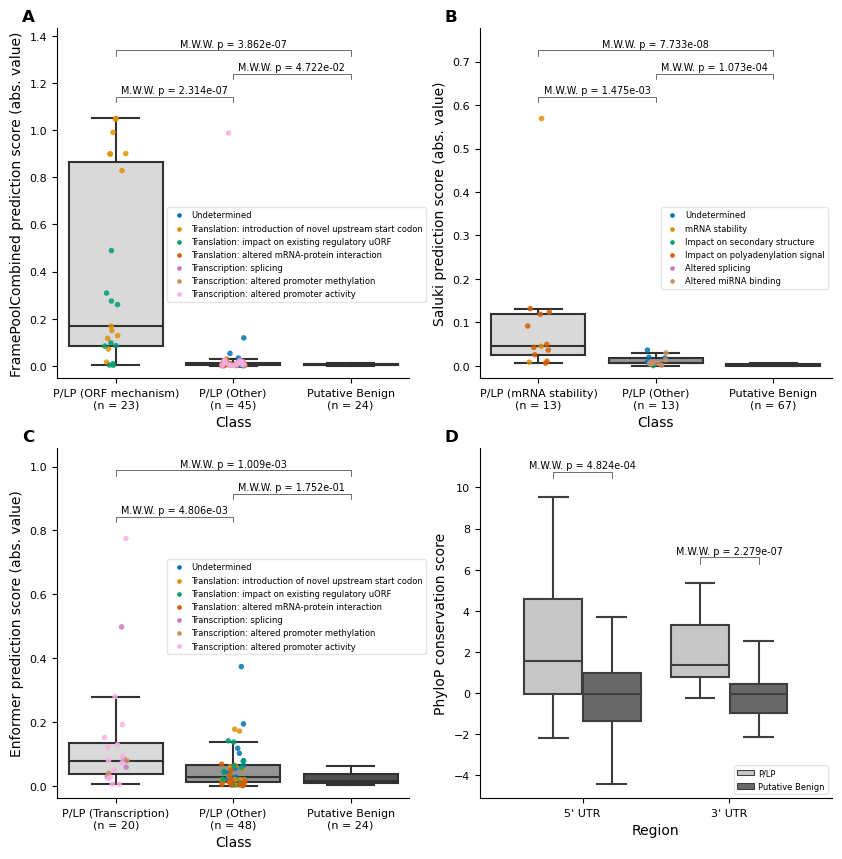

In [50]:

# figure
fig_av, axes_av = plt.subplots(2, 2, figsize=(10, 10))  # av = absolute value

# karollus
plp_orf = 'P/LP (ORF mechanism)'
plp_other = 'P/LP (Other)'
benign = 'Putative Benign'
order = [plp_orf, plp_other, benign]
pairs = [(plp_orf, benign), (plp_orf, plp_other), (plp_other, benign)]
create_boxplot(
    ax_n=axes_av[0,0],
    df=karollus_df,
    x='variant_annotation',
    y='abs_score',
    pairs=pairs,
    order=order,
    ylabel='FramePoolCombined prediction score (abs. value)',
    xlabel='Class',
    legend_loc=(0.3, 0.5)
)

# saluki
order = ['P/LP (mRNA stability)', 'P/LP (Other)', 'Putative Benign']
pairs = [(order[0], order[2]), (order[0], order[1]), (order[1], order[2])]
create_boxplot(
    ax_n=axes_av[0,1],
    df=saluki_df, x='variant_annotation', y='abs_score',
    order=order, pairs=pairs,
    ylabel='Saluki prediction score (abs. value)',
    xlabel='Class',
    legend_loc=(1, 0.5)
)

# enformer
order = ['P/LP (Transcription)', 'P/LP (Other)', 'Putative Benign']
pairs = [(order[0], order[2]), (order[0], order[1]), (order[1], order[2])]
create_boxplot(
    ax_n=axes_av[1,0],
    df=enformer_df, x='variant_annotation', y='abs_score',
    order=order, pairs=pairs,
    ylabel='Enformer prediction score (abs. value)',
    xlabel='Class',
    legend_loc=(0.3, 0.4)
)

create_polyphen_plot(ax_n=axes_av[1,1], phylop_results=phylop_results)

# OVERALL FIGURE - ADD SUBFIGURE LABELS
for n, ax in enumerate(axes_av.flat):
    ax.text(-0.1, 1.02, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=12, weight='bold')

# write output
fig_av
fig_av.savefig('plots/fig3_predictors_boxplots_absvalue.png', bbox_inches='tight',)


# ROC and PRC curves (Figure S4 and Figure S5)

We have shown that only the ORF mechanism variants have informative scores, so we will keep the benchmarking restricted to those variants for each of the models.

We will also do this for both the raw values and absolute values.

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt

def create_roc_prc_plots(df, x, y, absolute_values=False, phylop=False):
    x = df[x].to_numpy().ravel()
    if not absolute_values:
        x = -1 * x
    if phylop:
        x = -1 * x
    y = df[y].to_numpy().ravel()

    print(len(x))
    print(len(y))

    # ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, x) 
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
    roc_auc = metrics.auc(fpr, tpr)
    # PRC
    precision, recall, thresholds = metrics.precision_recall_curve(y, x) 
    prc_auc = metrics.auc(recall, precision)

    # plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    plt.setp(axes, xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))

    axes[0].plot(fpr, tpr)
    axes[0].set_title(f'ROC (AUC = {round(roc_auc, 3)})', fontsize=10)
    axes[0].set_xlabel('FPR', fontsize=8)
    axes[0].set_ylabel('TPR', fontsize=8)
    

    axes[1].plot(recall, precision)
    axes[1].set_title(f'PRC (AUC = {round(prc_auc, 3)})', fontsize=10)
    axes[1].set_xlabel('Recall', fontsize=8)
    axes[1].set_ylabel('Precision', fontsize=8)

    for ax in [axes[0], axes[1]]:
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    sns.despine()
    return roc_df


47
47
80
80
44
44


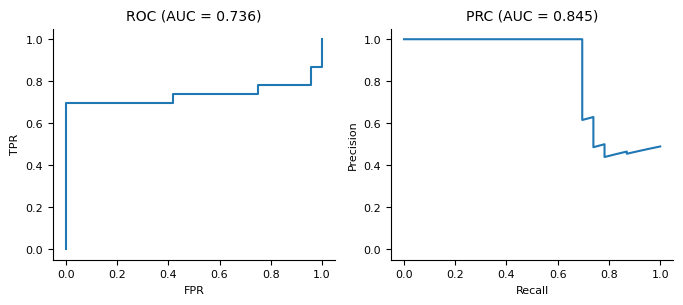

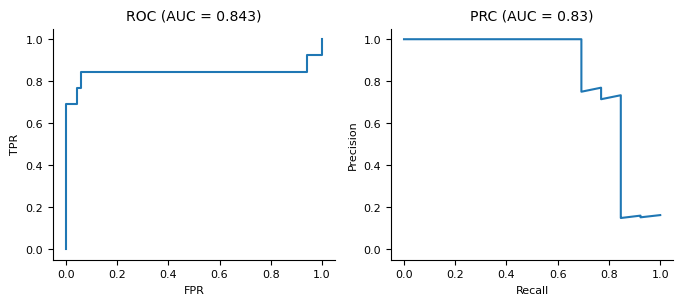

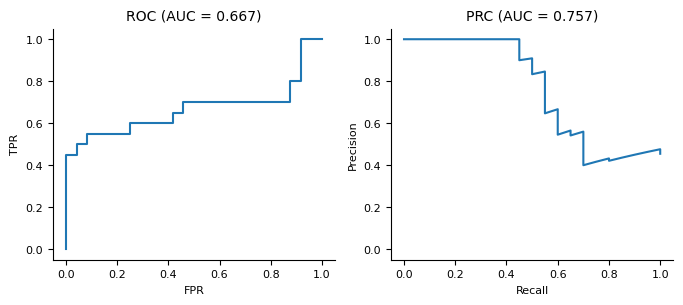

In [53]:
# Figure S4 - raw values first

# karollus
karollus_sub_df = karollus_df.query('(`proposed_mechanism`.isin(@orf_mechanisms)) | (`class` == 0)').query("mrl_fold_change.notnull()")
create_roc_prc_plots(karollus_sub_df, 'mrl_fold_change', 'class', absolute_values=False)
plt.savefig('plots/figS4_karollus_ROC.png', bbox_inches='tight')

# saluki
sub_saluki_df = saluki_df.query('(variant_annotation == "P/LP (mRNA stability)") | (`class` == 0)')
create_roc_prc_plots(sub_saluki_df, 'score', 'class', absolute_values=False)
plt.savefig('plots/figS4_saluki_ROC.png', bbox_inches='tight')

# enformer
enformer_sub_df = enformer_df.query(
    'variant_annotation == "P/LP (Transcription)" | `class` == 0'
).query("score.notnull()")
create_roc_prc_plots(enformer_sub_df, x='score', y='class', absolute_values=False)
plt.savefig('plots/figS4_enformer_ROC.png', bbox_inches='tight')


47
47
80
80
44
44


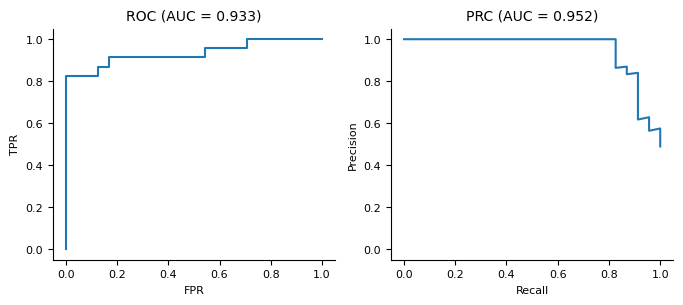

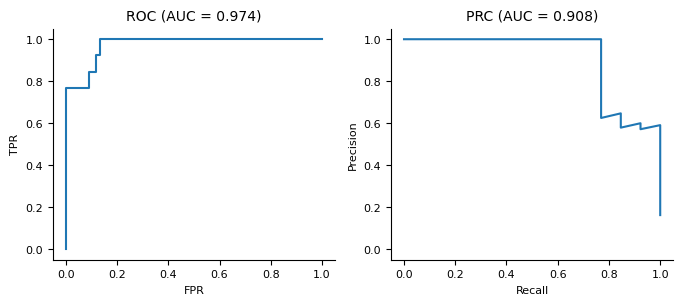

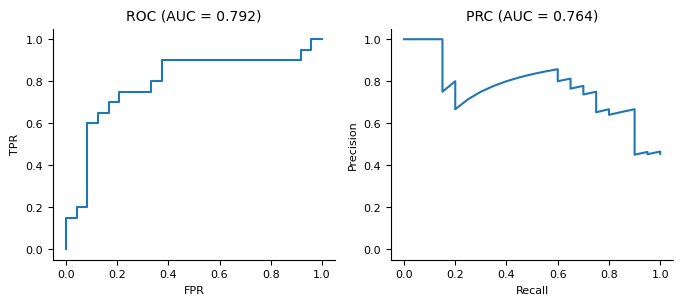

In [54]:
# Figure S5 - ROC and PRC using absolute values

# karollus
create_roc_prc_plots(karollus_sub_df, x='abs_score', y='class', absolute_values=True)
plt.savefig('plots/figS5_karollus_ROC_absvalue.png', bbox_inches='tight')

# saluki
create_roc_prc_plots(sub_saluki_df, x='abs_score', y='class', absolute_values=True)
plt.savefig('plots/figS5_saluki_ROC_absvalue.png', bbox_inches='tight')

# enformer
create_roc_prc_plots(enformer_sub_df, x='abs_score', y='class', absolute_values=True)
plt.savefig('plots/figS5_enformer_ROC_absvalue.png', bbox_inches='tight')

## Figure S6

Comparing conservation by mechanism. 

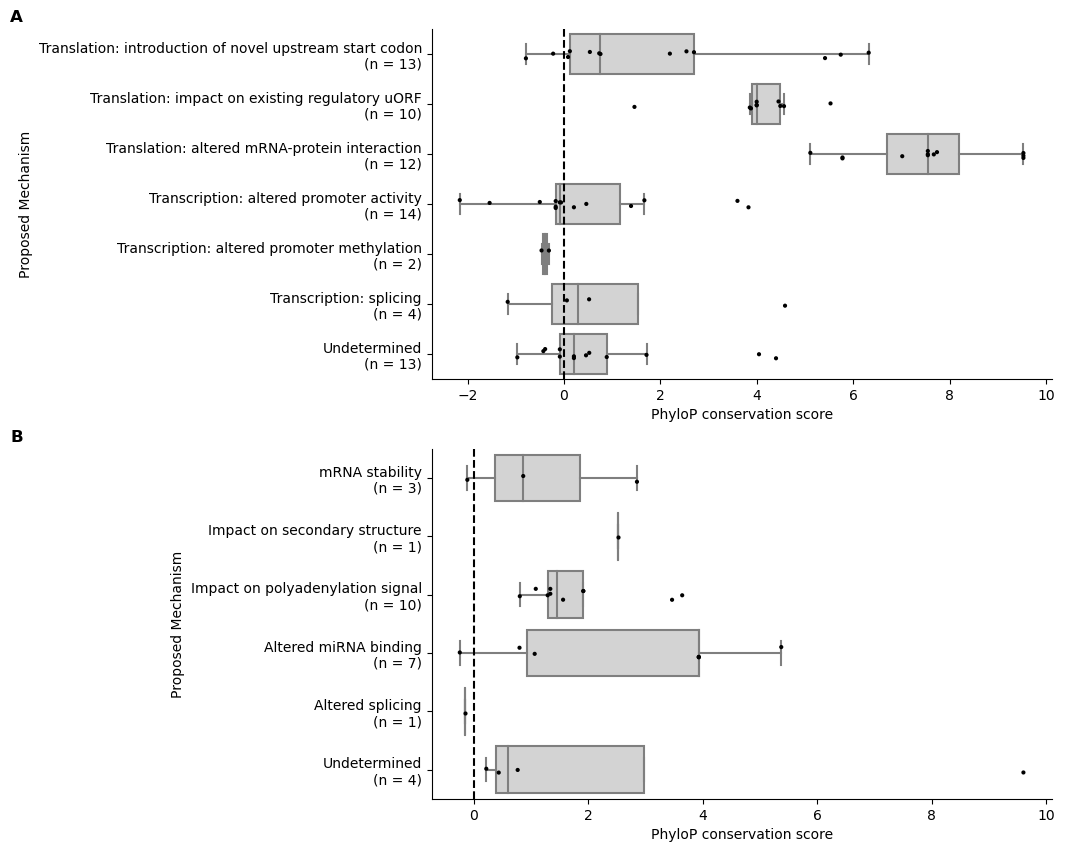

In [56]:
phylop_results

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))


# let's do the 5' UTR first
# manually define order by doing translation, transcription, and then unknown
temp = phylop_results.query("region == 'utr5'")["proposed_mechanism"].drop_duplicates().dropna().to_list()
order = [
    [x for x in temp if x.startswith("Translation")] +\
    [x for x in temp if x.startswith("Transcription")] +\
    ["Undetermined"]
]
flat = [item for sublist in order for item in sublist]
counts_dict = phylop_results.query("region == 'utr5'")["proposed_mechanism"].value_counts().to_dict()
labels = [f'{x}\n(n = {counts_dict[x]})' for x in flat]

def create_mechanism_phylop_plot(df, order, labels, ax_n):
    ax_n.clear()
    ax = sns.boxplot(
        ax=ax_n,
        data=df,
        x="phylop_100way",
        y="proposed_mechanism",
        color="Lightgrey",
        order=order,
        showfliers=False,
    )
    ax.axvline(x=0, color="black", linestyle="--")
    sns.stripplot(
        ax=ax_n,
        data=df,
        x="phylop_100way",
        y="proposed_mechanism",
        color="black",
        order=order,
        size=3,
        # hue="gene_name"
    )
    ax.set_yticklabels(labels)
    ax.set_ylabel("Proposed Mechanism")
    ax.set_xlabel("PhyloP conservation score")
    sns.despine()

create_mechanism_phylop_plot(phylop_results.query("region == 'utr5'"), flat, labels, ax_n=axes[0])

# manually order 3' UTR mechanisms
order = [
    'mRNA stability',
    'Impact on secondary structure',
    'Impact on polyadenylation signal',
    'Altered miRNA binding',
    'Altered splicing',
    'Undetermined'
]
counts_dict = phylop_results.query("region == 'utr3'")["proposed_mechanism"].value_counts().to_dict()
labels = [f'{x}\n(n = {counts_dict[x]})' for x in order]

create_mechanism_phylop_plot(phylop_results.query("region == 'utr3'"), order, labels, ax_n=axes[1])

# OVERALL FIGURE - ADD SUBFIGURE LABELS
for n, ax in enumerate(axes.flat):
    ax.text(-0.68, 1.02, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=12, weight='bold')


fig.savefig("plots/figS6_phylop_by_mechanism.png", bbox_inches="tight")
